
# Advanced Data Science Capstone

## Correlation of air pollution and Prevalence of Asthma bronchiale in Germany  

## Exploratory research

### Data sources
As data sources I use the data sets officially published by **Geschäfts- und Koordinierungsstelle GovData**, the search engine is available at https://www.govdata.de/web/guest/suchen.
The list of relevant data sets is following:

## Air quality:

Data stream **E1a** contains measured (Link to Data stream D) values of gas phase pollutants (e.g. Ozone, NO2, SO2, CO), particle pollutants (e.g. dust) and dust constituants (e.g. heavy metals, PAK in PM10, PM2.5, TSP) as well es total deposition (BULK), wet deposition and meteorologic data (e.g. temperature, wind, pressure)for every measurement location.

The data for years 2013 - 2018 is available. For the exploratory research I will limit myself with 2016 data,
since there are no principal difference with the other years data. Some examples of access to 2017 and 2018 year data are also shown in the present notebook.

Compressed dataset is available at https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2016.zip.

 - Air quality data (Datastream E1a) - Validated measurements from 2016 (Dataset).
   - Metadata in RDF format: https://www.govdata.de/ckan/dataset/luftqualitatsdaten-datenstrom-e1a-validierte-einzelwerte-2016-datensatz.rdf .
   - ATOM: Air quality data (INSPIRE Download/Atom Feed): https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Service_5e7bb800-c1db-4343-ac3e-a63204b0f6b7.atom.xml (currently N/A, *Invalid URL, Code: 400*)
   - XML-Metadata: Air quality data (Datastream E1a) - Validated measurements from 2016: http://www.geoportal.de/gds/xml.php?uuid=03e2d1ac-70dd-4664-8a46-9f5f6b756fe1
   
 - Positions of the air quality sensors (Datastream D): https://www.govdata.de/ckan/dataset/luftqualitatsdaten-datenstrom-d-beurteilungsmethoden-2016-datensatz.rdf.
 
 - Health related data
   - Asthma bronchiale prevalence: https://www.versorgungsatlas.de/fileadmin/excel/data_id_92_kreis11_1_j_1451606400.xlsx contains county-averaged data on prevalence of Asthma bronchiale for year 2016.
   - Also the data for other diseases and years (without full coverage), as well as Self-evaluation of the health status, on the county-averaged basis can be found at this site.
   
 - Auxiliary information
   - In order to connect the datasets from different origin, one need to have a geotagging in the same format.
The easiest way is to stick on county-based data, attribute all air pollution sensors positions to corresponding counties. 
   - The data set containing the information on German towns and counties can be found at https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/Archiv/GV100ADQ/GV100AD3107.zip?__blob=publicationFile.

### Initial Data Exploration
 - Load the data set and check it's structure, size and data quality (non-informative entries, data variability)
 - If the data set is big, make a sample subset
 - Make exploratory plots
  
### Loading all necessary libraries:

In [1]:
###import rdfpandas as pd
#!pip install rdflib
#!pip install networkx
#!pip install xlrd

import urllib.request
import xml.etree.ElementTree as ET
from lxml import etree
import pandas as pd
import numpy as np

import re, collections
from io import StringIO
import os, fnmatch

import matplotlib.pyplot as plt

### Creating function for printing XML file structure
It will be useful, since almost all data at GovData.de is kept in *xml* format.

In [2]:
def PrintXML(XMLfileName):
    xml_root = (etree.parse(XMLfileName)).getroot()
    raw_tree = etree.ElementTree(xml_root)
    nice_tree = collections.OrderedDict()

    for tag in xml_root.iter():
        path = re.sub('\[[0-9]+\]', '', raw_tree.getpath(tag))
        if path not in nice_tree:
            nice_tree[path] = []
        if len(tag.keys()) > 0:
            nice_tree[path].extend(attrib for attrib in tag.keys() if attrib not in nice_tree[path])            
 
    for path, attribs in nice_tree.items():
        indent = int(path.count('/') - 1)
        print('{0}{1}: {2} [{3}]'.format('    ' * indent, indent, path.split('/')[-1], ', '.join(attribs) if len(attribs) > 0 else '-'))

### Downloading the data

In [3]:
!rm -rf ./Capstone.rawData
## Download and decompress the dataset itself:
!mkdir Capstone.rawData
!ls -l Capstone.rawData/

##### Pollution 2016
!mkdir Capstone.rawData/AQD_DE_E1a_2016
urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2016.zip", "Capstone.rawData/AQD_DE_E1a_2016.zip")
!mv Capstone.rawData/AQD_DE_E1a_2016.zip Capstone.rawData/AQD_DE_E1a_2016/
!unzip Capstone.rawData/AQD_DE_E1a_2016/AQD_DE_E1a_2016.zip -d Capstone.rawData/
!rm Capstone.rawData/AQD_DE_E1a_2016/AQD_DE_E1a_2016.zip

##### Pollution 2017
#!mkdir Capstone.rawData/AQD_DE_E1a_2017
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2017.zip", "Capstone.rawData/AQD_DE_E1a_2017.zip")
#!mv Capstone.rawData/AQD_DE_E1a_2017.zip Capstone.rawData/AQD_DE_E1a_2017/
#!unzip Capstone.rawData/AQD_DE_E1a_2017/AQD_DE_E1a_2017.zip -d Capstone.rawData/
#!rm Capstone.rawData/AQD_DE_E1a_2017/AQD_DE_E1a_2017.zip
#!unzip Capstone.rawData/AQD_DE_E1a_2017/DISKO.zip -d Capstone.rawData/AQD_DE_E1a_2017/
#!unzip Capstone.rawData/AQD_DE_E1a_2017/KONTI.zip -d Capstone.rawData/AQD_DE_E1a_2017/
#!rm Capstone.rawData/AQD_DE_E1a_2017/DISKO.zip Capstone.rawData/AQD_DE_E1a_2017/KONTI.zip

##### Pollution 2018
#!mkdir Capstone.rawData/AQD_DE_E1a_2018
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2018.zip", "Capstone.rawData/AQD_DE_E1a_2018.zip")
#!mv Capstone.rawData/AQD_DE_E1a_2018.zip Capstone.rawData/AQD_DE_E1a_2018/
#!unzip Capstone.rawData/AQD_DE_E1a_2018/AQD_DE_E1a_2018.zip -d Capstone.rawData/
#!rm Capstone.rawData/AQD_DE_E1a_2018/AQD_DE_E1a_2018.zip
#!mv ./Capstone.rawData/E1a/* Capstone.rawData/AQD_DE_E1a_2018/
#!rm -rf Capstone.rawData/E1a

##Download the dataset Metadata xml
urllib.request.urlretrieve("http://www.geoportal.de/gds/xml.php?uuid=03e2d1ac-70dd-4664-8a46-9f5f6b756fe1", "Capstone.rawData/AQD_DE_E1a_2016/E1a2016_meta.xml")
#urllib.request.urlretrieve("http://www.geoportal.de/gds/xml.php?uuid=cdadb71f-5571-4c95-af2a-d926efb4e3a0", "Capstone.rawData/AQD_DE_E1a_2018/E1a2018_meta.xml")
#urllib.request.urlretrieve("http://www.geoportal.de/gds/xml.php?uuid=c533b9a5-e518-4bf8-9a0a-1b829acd561d", "Capstone.rawData/AQD_DE_E1a_2017/E1a2017_meta.xml") 

##Download Sensor positions
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_D_2017.zip", "Capstone.rawData/AQD_DE_D_2017.zip")
#!unzip Capstone.rawData/AQD_DE_D_2017.zip -d Capstone.rawData/
#!rm Capstone.rawData/AQD_DE_D_2017.zip
urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_D_2016.zip", "Capstone.rawData/AQD_DE_D_2016.zip")
!unzip Capstone.rawData/AQD_DE_D_2016.zip -d Capstone.rawData/
!rm Capstone.rawData/AQD_DE_D_2016.zip


## Download Town-county dataset:
urllib.request.urlretrieve("https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/Archiv/GV100ADQ/GV100AD3107.zip?__blob=publicationFile",
                           "Capstone.rawData/GV100AD3107.zip")
!mkdir Capstone.rawData/GV100AD3107
!unzip Capstone.rawData/GV100AD3107.zip -d Capstone.rawData/GV100AD3107/
!rm Capstone.rawData/GV100AD3107.zip


#!ls -la Capstone.rawData/AQD_DE_E1a_2017/
#!pwd

total 0
Archive:  Capstone.rawData/AQD_DE_E1a_2016/AQD_DE_E1a_2016.zip
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_NO2_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_NOx_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_NO_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_O3_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_PM1_day.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_PM1_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_PM2_day.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_PM2_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_SO2_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SL_2016_CO_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SL_2016_NO2_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SL_2016_NO_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SL_2016_O3_hour.xml  


###### Metadata XML file
Now let's take a look at the downloaded *E1a2016_meta.xml* file.
First print it's structure

In [4]:
PrintXML("Capstone.rawData/AQD_DE_E1a_2016/E1a2016_meta.xml")

0: gmd:MD_Metadata [{http://www.w3.org/2001/XMLSchema-instance}schemaLocation]
    1: gmd:fileIdentifier [-]
        2: gco:CharacterString [-]
    1: gmd:language [-]
        2: * [codeList, codeListValue]
    1: gmd:characterSet [-]
        2: * [codeList, codeListValue]
    1: gmd:hierarchyLevel [-]
        2: * [codeList, codeListValue]
    1: gmd:hierarchyLevelName [-]
        2: gco:CharacterString [-]
    1: gmd:contact [-]
        2: gmd:CI_ResponsibleParty [-]
            3: gmd:individualName [-]
                4: gco:CharacterString [-]
            3: gmd:organisationName [-]
                4: gco:CharacterString [-]
            3: gmd:positionName [-]
                4: gco:CharacterString [-]
            3: gmd:contactInfo [-]
                4: gmd:CI_Contact [-]
                    5: gmd:phone [-]
                        6: gmd:CI_Telephone [-]
                            7: gmd:voice [-]
                                8: gco:CharacterString [-]
                     

This give us almost no information about the dataset.
Finally, printing out parsed *xml* file (it is not so big, just 37 kB, for code see commented chunk below) I found,
that it contains urls to data formats and standards: http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode, https://registry.gdi-de.org/id/de.bund.uba.inspire.aqd/cdadb71f-5571-4c95-af2a-d926efb4e3a0, etc.

Also it contains description of the measurement details: *Datenstrom E1a umfasst gemessene (Link zu Datenstrom D) Einzelwerte von gasförmigen Schadstoffen (z. B. Ozon, Stickstoffdixoid, Schwefeldioxid, Kohlenmonoxid), von partikelförmigen Schadstoffen (z.B. Feinstaub, Ruß, Gesamtstaub) und Staubinhaltsstoffen (z.B. Schwermetalle, PAK in PM10, PM2.5, TSP) sowie der Gesamtdeposition (BULK), der nassen Deposition und meteorologische Messgrößen (z.B. Temperatur, Windgeschwindigkeit, Luftdruck), für die eine Datenbereitstellungspflicht besteht. Der Bericht umfasst zudem die Datenqualitätsziele (Messunsicherheit, Mindestzeiterfassung (time coverage) erfüllt ja/nein, Mindestdatenerfassung (data capture) erfüllt ja/nein) und Informationen zu Konzentrationswerten die natürlichen Quellen und der Ausbringung von Streusand und –salz zuzurechnen sind (Konzentrationswerte ohne etwaige Korrekturabzüge)*.

Since I will normalize the data anyway, the only important thing is that **all the data sets are using the same units**. However the units of measurements are also mentioned in the data files themselves, as it will be shown later, so these metadata files are out of use, at least for the moment.

In [5]:
#import xml.dom.minidom
#with open('Capstone.rawData/AQD_DE_E1a_2018/E1a2018_meta.xml', encoding='utf-8') as xmldata:
#    xml = xml.dom.minidom.parseString(xmldata.read())  # or xml.dom.minidom.parseString(xml_string)
#    xml_pretty_str = xml.toprettyxml()
#print(xml_pretty_str)

### Dataset files analysis
Let's take a look at the downloaded data set:

In [6]:
!ls -la Capstone.rawData/AQD_DE_E1a_2016/

total 297244
drwxr-x--- 2 dsxuser dsxuser     4096 Aug 15 08:04 .
drwxr-x--- 4 dsxuser dsxuser     4096 Aug 15 08:04 ..
-rw-r----- 1 dsxuser dsxuser  6803692 Apr 19  2018 DE_SH_2016_NO2_hour.xml
-rw-r----- 1 dsxuser dsxuser  6712715 Apr 19  2018 DE_SH_2016_NO_hour.xml
-rw-r----- 1 dsxuser dsxuser  6802174 Apr 19  2018 DE_SH_2016_NOx_hour.xml
-rw-r----- 1 dsxuser dsxuser  5673016 Apr 19  2018 DE_SH_2016_O3_hour.xml
-rw-r----- 1 dsxuser dsxuser   125170 Apr 19  2018 DE_SH_2016_PM1_day.xml
-rw-r----- 1 dsxuser dsxuser  3954075 Apr 19  2018 DE_SH_2016_PM1_hour.xml
-rw-r----- 1 dsxuser dsxuser    64316 Apr 19  2018 DE_SH_2016_PM2_day.xml
-rw-r----- 1 dsxuser dsxuser  3927142 Apr 19  2018 DE_SH_2016_PM2_hour.xml
-rw-r----- 1 dsxuser dsxuser   557581 Apr 19  2018 DE_SH_2016_SO2_hour.xml
-rw-r----- 1 dsxuser dsxuser  1658891 Apr 19  2018 DE_SL_2016_CO_hour.xml
-rw-r----- 1 dsxuser dsxuser  5028403 Apr 19  2018 DE_SL_2016_NO2_hour.xml
-rw-r----- 1 dsxuser dsxuser  4961921 Apr 19  2018 DE_SL_201

It is clear, that filenames contain information on the file contents:
e.g. **DE_SH_2016_NOx_hour.xml**: **DE** for Germany, **SH** for Schleswig-Holstein region, **2016** for year of measurements, **NOx** for kind of pollutant (nitrogen oxides), **hour** for type of measurements.  

Now let's take a look at the *xml* file structure:

In [7]:

PrintXML("Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_NOx_hour.xml")


0: gml:FeatureCollection [{http://www.w3.org/2001/XMLSchema-instance}schemaLocation, {http://www.opengis.net/gml/3.2}id]
    1: gml:featureMember [-]
        2: om:OM_Observation [{http://www.opengis.net/gml/3.2}id]
            3: om:phenomenonTime [-]
                4: gml:TimePeriod [{http://www.opengis.net/gml/3.2}id]
                    5: gml:beginPosition [-]
                    5: gml:endPosition [-]
            3: om:resultTime [-]
                4: gml:TimeInstant [{http://www.opengis.net/gml/3.2}id]
                    5: gml:timePosition [-]
            3: om:procedure [{http://www.w3.org/1999/xlink}href]
            3: om:parameter [-]
                4: om:NamedValue [-]
                    5: om:name [{http://www.w3.org/1999/xlink}href]
                    5: om:value [{http://www.w3.org/1999/xlink}href, {http://www.w3.org/2001/XMLSchema-instance}type]
            3: om:observedProperty [{http://www.w3.org/1999/xlink}href]
            3: om:featureOfInterest [{http://ww

Again, a lot of urls describing standards, however the structure of file becomes clearer.
Let's check the first rank entries from the root:

In [8]:
xml_tree = etree.parse("Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_NOx_hour.xml")
xml_root = xml_tree.getroot()
for child in xml_root:
    print(child.tag, child.attrib) 

{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}


It looks like  that the file contains measurements from 13 sensors at different locations (as it will be shown later, actual file contains only 12 sensors data, the first entry is used for auxiliary information). 
An *xml* file entry consist of three possible elements: **tag**, like key or variable name; **attrib**, like value of variable, and **text**, that accommodates everything between corresponding tags (up to video in *base64* encoding). 
For the further use I will collect all the **tag**s from the dataset file and store it to the *AllTags* list.


In [9]:
# pick all tags from the XML file
Etree = ET.parse("Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_NOx_hour.xml")
Eroot = Etree.getroot()
Eroot.tag
Eroot.attrib
AllTags = [elem.tag for elem in Eroot.iter()]
print(AllTags[23:35])
#varName = 'observedProperty'
#print("\n".join([s for s in AllTags if varName in s]))    

['{http://www.isotc211.org/2005/gmd}result', '{http://www.isotc211.org/2005/gmd}DQ_ConformanceResult', '{http://www.isotc211.org/2005/gmd}specification', '{http://www.isotc211.org/2005/gmd}CI_Citation', '{http://www.isotc211.org/2005/gmd}title', '{http://www.isotc211.org/2005/gco}CharacterString', '{http://www.isotc211.org/2005/gmd}date', '{http://www.isotc211.org/2005/gmd}CI_Date', '{http://www.isotc211.org/2005/gmd}date', '{http://www.isotc211.org/2005/gco}Date', '{http://www.isotc211.org/2005/gmd}dateType', '{http://www.isotc211.org/2005/gmd}CI_DateTypeCode']


## Exploring Dataset XML structure
First of all, let's write functions, that will fetch *xml* tags by contained keyword.
The ideas about keywords needed can be got from looking at *AllTags* list.
The function *FetchAllXMLsensor* parses the sensor ID from the corresponding *xml* **attr**
at the **value** tag.

In [10]:
def FetchXMLentryByWord(varName, NumToPrint):
    varFull = [s for s in AllTags if varName in s][NumToPrint]
    print(varFull)
    print([(varr.attrib, varr.text) for varr in Eroot.iter(varFull)][NumToPrint])
    print('\n')
def FetchAllXMLentriesByWord(varName):
    varFull = [s for s in AllTags if varName in s][0]
    print([(varr.attrib) for varr in Eroot.iter(varFull)])
    print('\n')
def FetchAllXMLsensorID():
    varFull = [s for s in AllTags if 'value' in s][0]
    print([re.sub(r'[^a-zA-Z0-9:]*\'{http(.*)$', r'', re.sub(r'^.*AQD\/SPO.DE_', r'', str(varr.attrib))) for varr in Eroot.iter(varFull) if 'AQD' in str(varr.attrib)]) 
    print('\n')
def SelectAllXMLsensorID():
    varFull = [s for s in AllTags if 'value' in s][0]
    return([re.sub(r'[^a-zA-Z0-9:]*\'{http(.*)$', r'', re.sub(r'^.*AQD\/SPO.DE_', r'', str(varr.attrib))) for varr in Eroot.iter(varFull) if 'AQD' in str(varr.attrib)]) 
    

Using the Fetch functions, one can show, that units of measurements in this *xml* file are **microgramm pro cubic meter**, the pollutant is of type 9 (according to the given url it is **NOX as NO2**)  and observation time os an **hour**. 

One can parse sensor IDs in form of **DESH008_NOx_dataGroup1**,
where **DE** stands for Germany, **SH** for Schleswig-Holstein region, **008** is the sensor number (this information will be used later for geotagging), **NOx** for kind of pollutant (nitrogen oxides), and the **dataGroup1** is some common index (it is the same for all the data sets).

The pollutant concentration data is stored in **text** fields of the entries with **value** tag; the data is stored in the *csv* format, end line symbol is "@@":

In [11]:
FetchXMLentryByWord('Quantity', 0)

FetchXMLentryByWord('uom', 2)    
FetchXMLentryByWord('observedProperty', 0)    

FetchAllXMLsensorID()

FetchXMLentryByWord('TextEncoding', 0)
ColNamesExp=SelectAllXMLsensorID()

{http://www.opengis.net/swe/2.0}Quantity
({'definition': 'http://dd.eionet.europa.eu/vocabulary/aq/primaryObservation/hour'}, '\n                ')


{http://www.opengis.net/swe/2.0}uom
({'{http://www.w3.org/1999/xlink}href': 'http://dd.eionet.europa.eu/vocabulary/uom/concentration/ug.m-3'}, None)


{http://www.opengis.net/om/2.0}observedProperty
({'{http://www.w3.org/1999/xlink}href': 'http://dd.eionet.europa.eu/vocabulary/aq/pollutant/9'}, None)


['DESH008_NOx_dataGroup1', 'DESH022_NOx_dataGroup1', 'DESH023_NOx_dataGroup1', 'DESH025_NOx_dataGroup1', 'DESH027_NOx_dataGroup1', 'DESH028_NOx_dataGroup1', 'DESH030_NOx_dataGroup1', 'DESH033_NOx_dataGroup1', 'DESH035_NOx_dataGroup1', 'DESH052_NOx_dataGroup1', 'DESH053_NOx_dataGroup1', 'DESH055_NOx_dataGroup1']


{http://www.opengis.net/swe/2.0}TextEncoding
({'decimalSeparator': '.', 'tokenSeparator': ',', 'blockSeparator': '@@'}, None)




## Reading Pollutant concentration Measurements to DataFrame
For exploratory analysis the data should be loaded to some toolbox, in this case **Pandas** in form of **Pandas Dataframe**. As it was shown before, one have to parse **text** fields of the entries with **value** tag as a normal *csv* file: 

In [12]:
varFull = [s for s in AllTags if 'values' in s][0]

dff=[]
for varr in Eroot.iter(varFull):
    dff.append(pd.read_csv(StringIO((varr.text).replace("@@","\n")), sep=",", header=None))

In [13]:
[dff[s].shape for s in range(0,len(dff))]

[(8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5)]

In [14]:
dff[11].tail(5)

,0,1,2,3,4
8779,2016-12-31T19:00:00+01:00,2016-12-31T20:00:00+01:00,1,1,49.092
8780,2016-12-31T20:00:00+01:00,2016-12-31T21:00:00+01:00,1,1,43.717
8781,2016-12-31T21:00:00+01:00,2016-12-31T22:00:00+01:00,1,1,46.305
8782,2016-12-31T22:00:00+01:00,2016-12-31T23:00:00+01:00,1,1,43.993
8783,2016-12-31T23:00:00+01:00,2016-12-31T24:00:00+01:00,1,1,43.253


From the chunks above one can see that in the current **DE_SH_2016_NOx_hour.xml** file there is measurement data for 12 sensors, each containing **8784 = 8760 + 24** values - one measurement for each hour of the year (2016 was a **leap year**). At least in the current file there are no NA values:

In [15]:
[dff[s].isnull().sum() for s in range(0,len(dff))]

[0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64]

<Figure size 432x288 with 0 Axes>

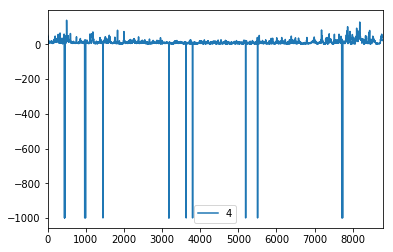

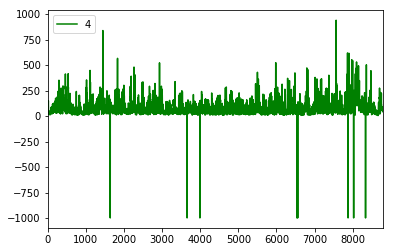

In [16]:
plt.figure()
((dff[0])[[4]]).plot()
((dff[11])[[4]]).plot(style='g')


From the figures above it is clear that the data contains also **failed measurements, encoded as negative values** (pollutant concentration cannot be negative). It means that *imputting* strategy should be developed in order to treat the problem. At the moment these negative values will be replaced with zeros, it will cause no problem for initial exploratory analysis:

In [17]:
dffAll=pd.concat([dff[s][4] for s in range(0,len(dff))], axis=1)
dffAll.columns=ColNamesExp
dffAll=dffAll.clip(lower=0)
dffAll.head(5)

,DESH008_NOx_dataGroup1,DESH022_NOx_dataGroup1,DESH023_NOx_dataGroup1,DESH025_NOx_dataGroup1,DESH027_NOx_dataGroup1,DESH028_NOx_dataGroup1,DESH030_NOx_dataGroup1,DESH033_NOx_dataGroup1,DESH035_NOx_dataGroup1,DESH052_NOx_dataGroup1,DESH053_NOx_dataGroup1,DESH055_NOx_dataGroup1
0,51.264,157.599,68.843,139.806,79.911,91.980,335.296,54.370,35.921,78.128,168.864,111.040
1,45.793,107.566,24.563,111.851,80.667,64.599,303.718,35.988,19.120,96.328,82.379,65.596
2,37.620,152.549,22.639,78.771,65.762,79.785,232.949,36.710,20.830,92.646,70.011,56.897
3,43.609,100.344,23.416,53.366,44.611,57.478,131.797,26.302,21.533,68.953,85.058,44.712
4,45.962,126.367,24.057,51.263,47.944,52.770,127.609,26.711,26.515,42.145,51.796,81.346


Now we can plot selected **DE_SH_2016_NOx_hour.xml** file as a timeseries: 

<Figure size 2592x1296 with 0 Axes>

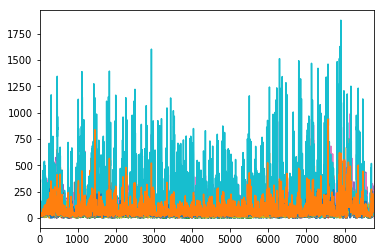

In [18]:
plt.figure(figsize=(36,18))
dffAll.plot(legend=None)

However for such a long-term effects as a public health impact, some derived quantities, like *number of days in year with too high pollutant concentration*, or some other integral quantities will be used. At the current stage a summary over the year w.r.t. the sensors can be done:

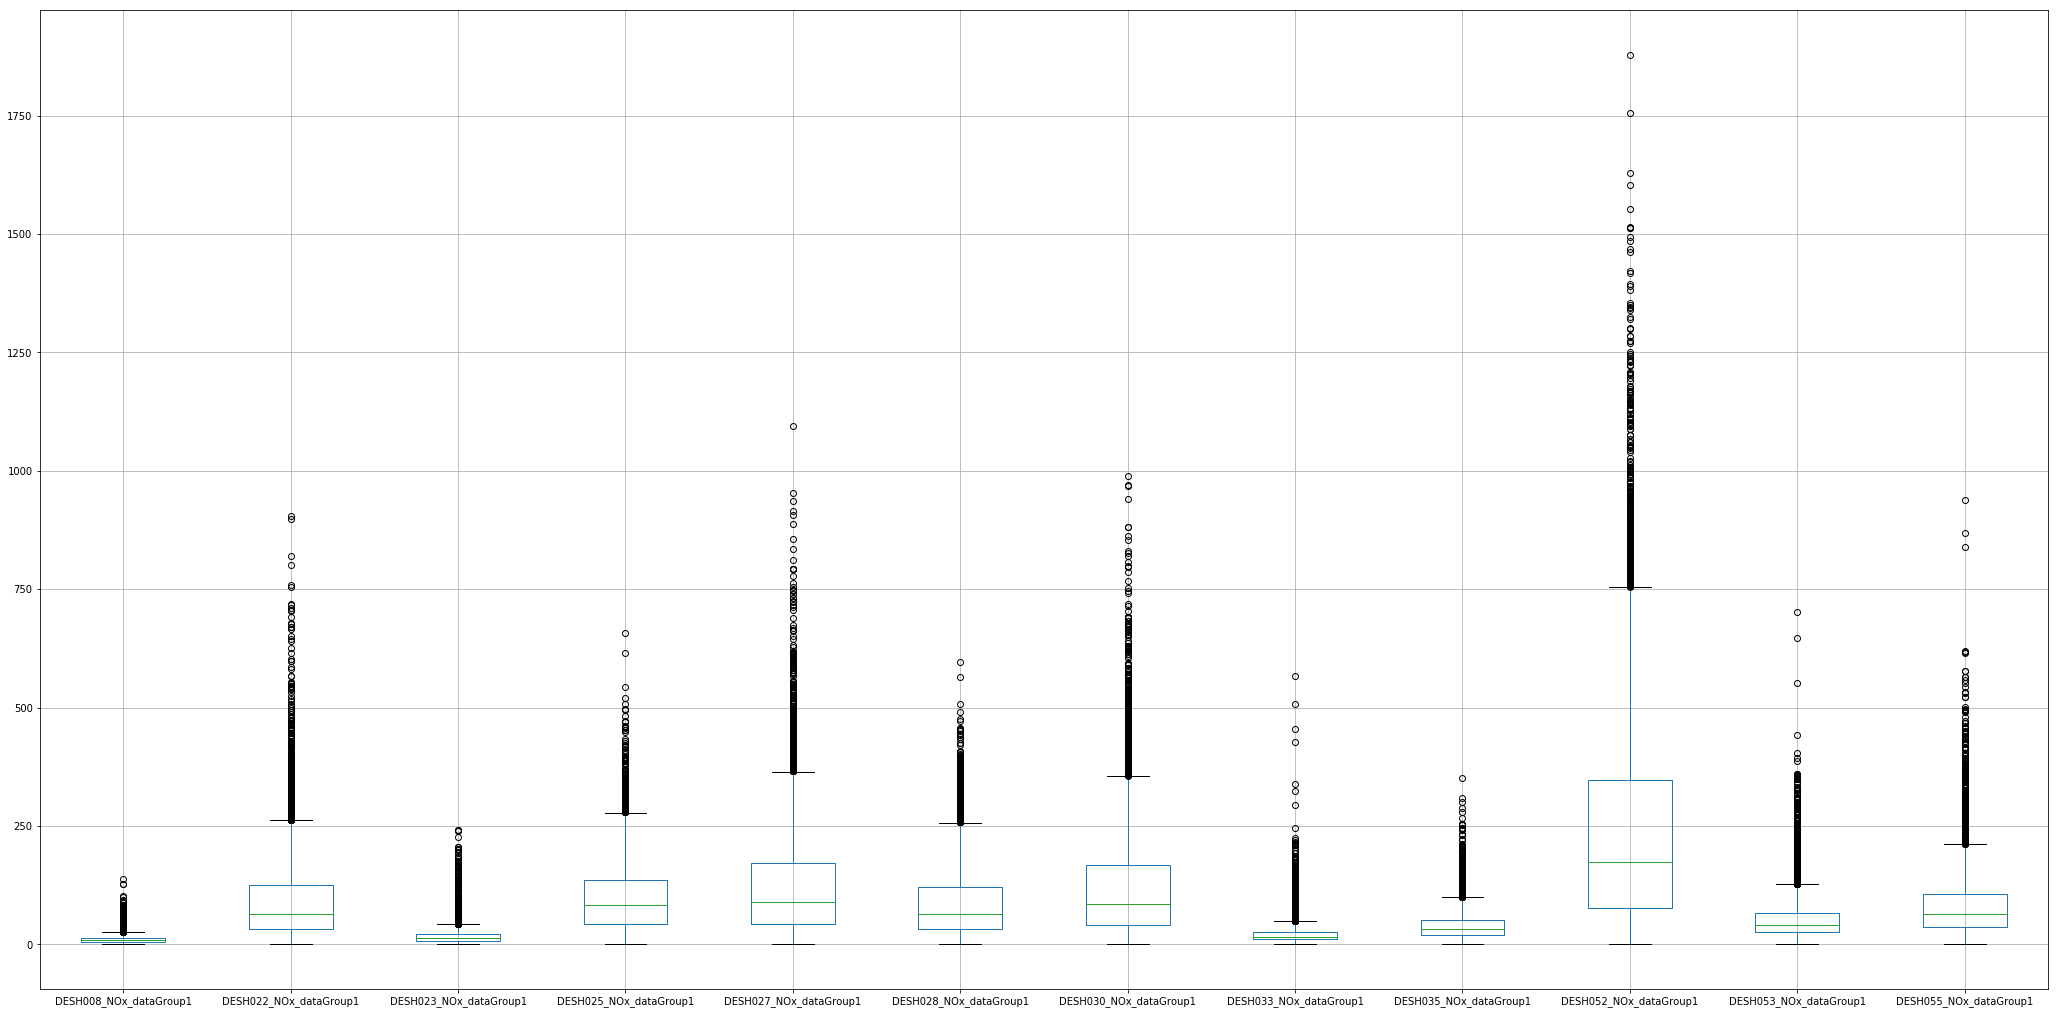

In [19]:
plt.figure(figsize=(36,18))
dffAll.boxplot()

On the figure above one can see that different sensors demonstrate significantly different statistics, so the data variativity should be enough to be used in the project. Also a quick check of the sanity of the whole pollutant dataset could be done by plotting all the files in the manner showed above: 

51


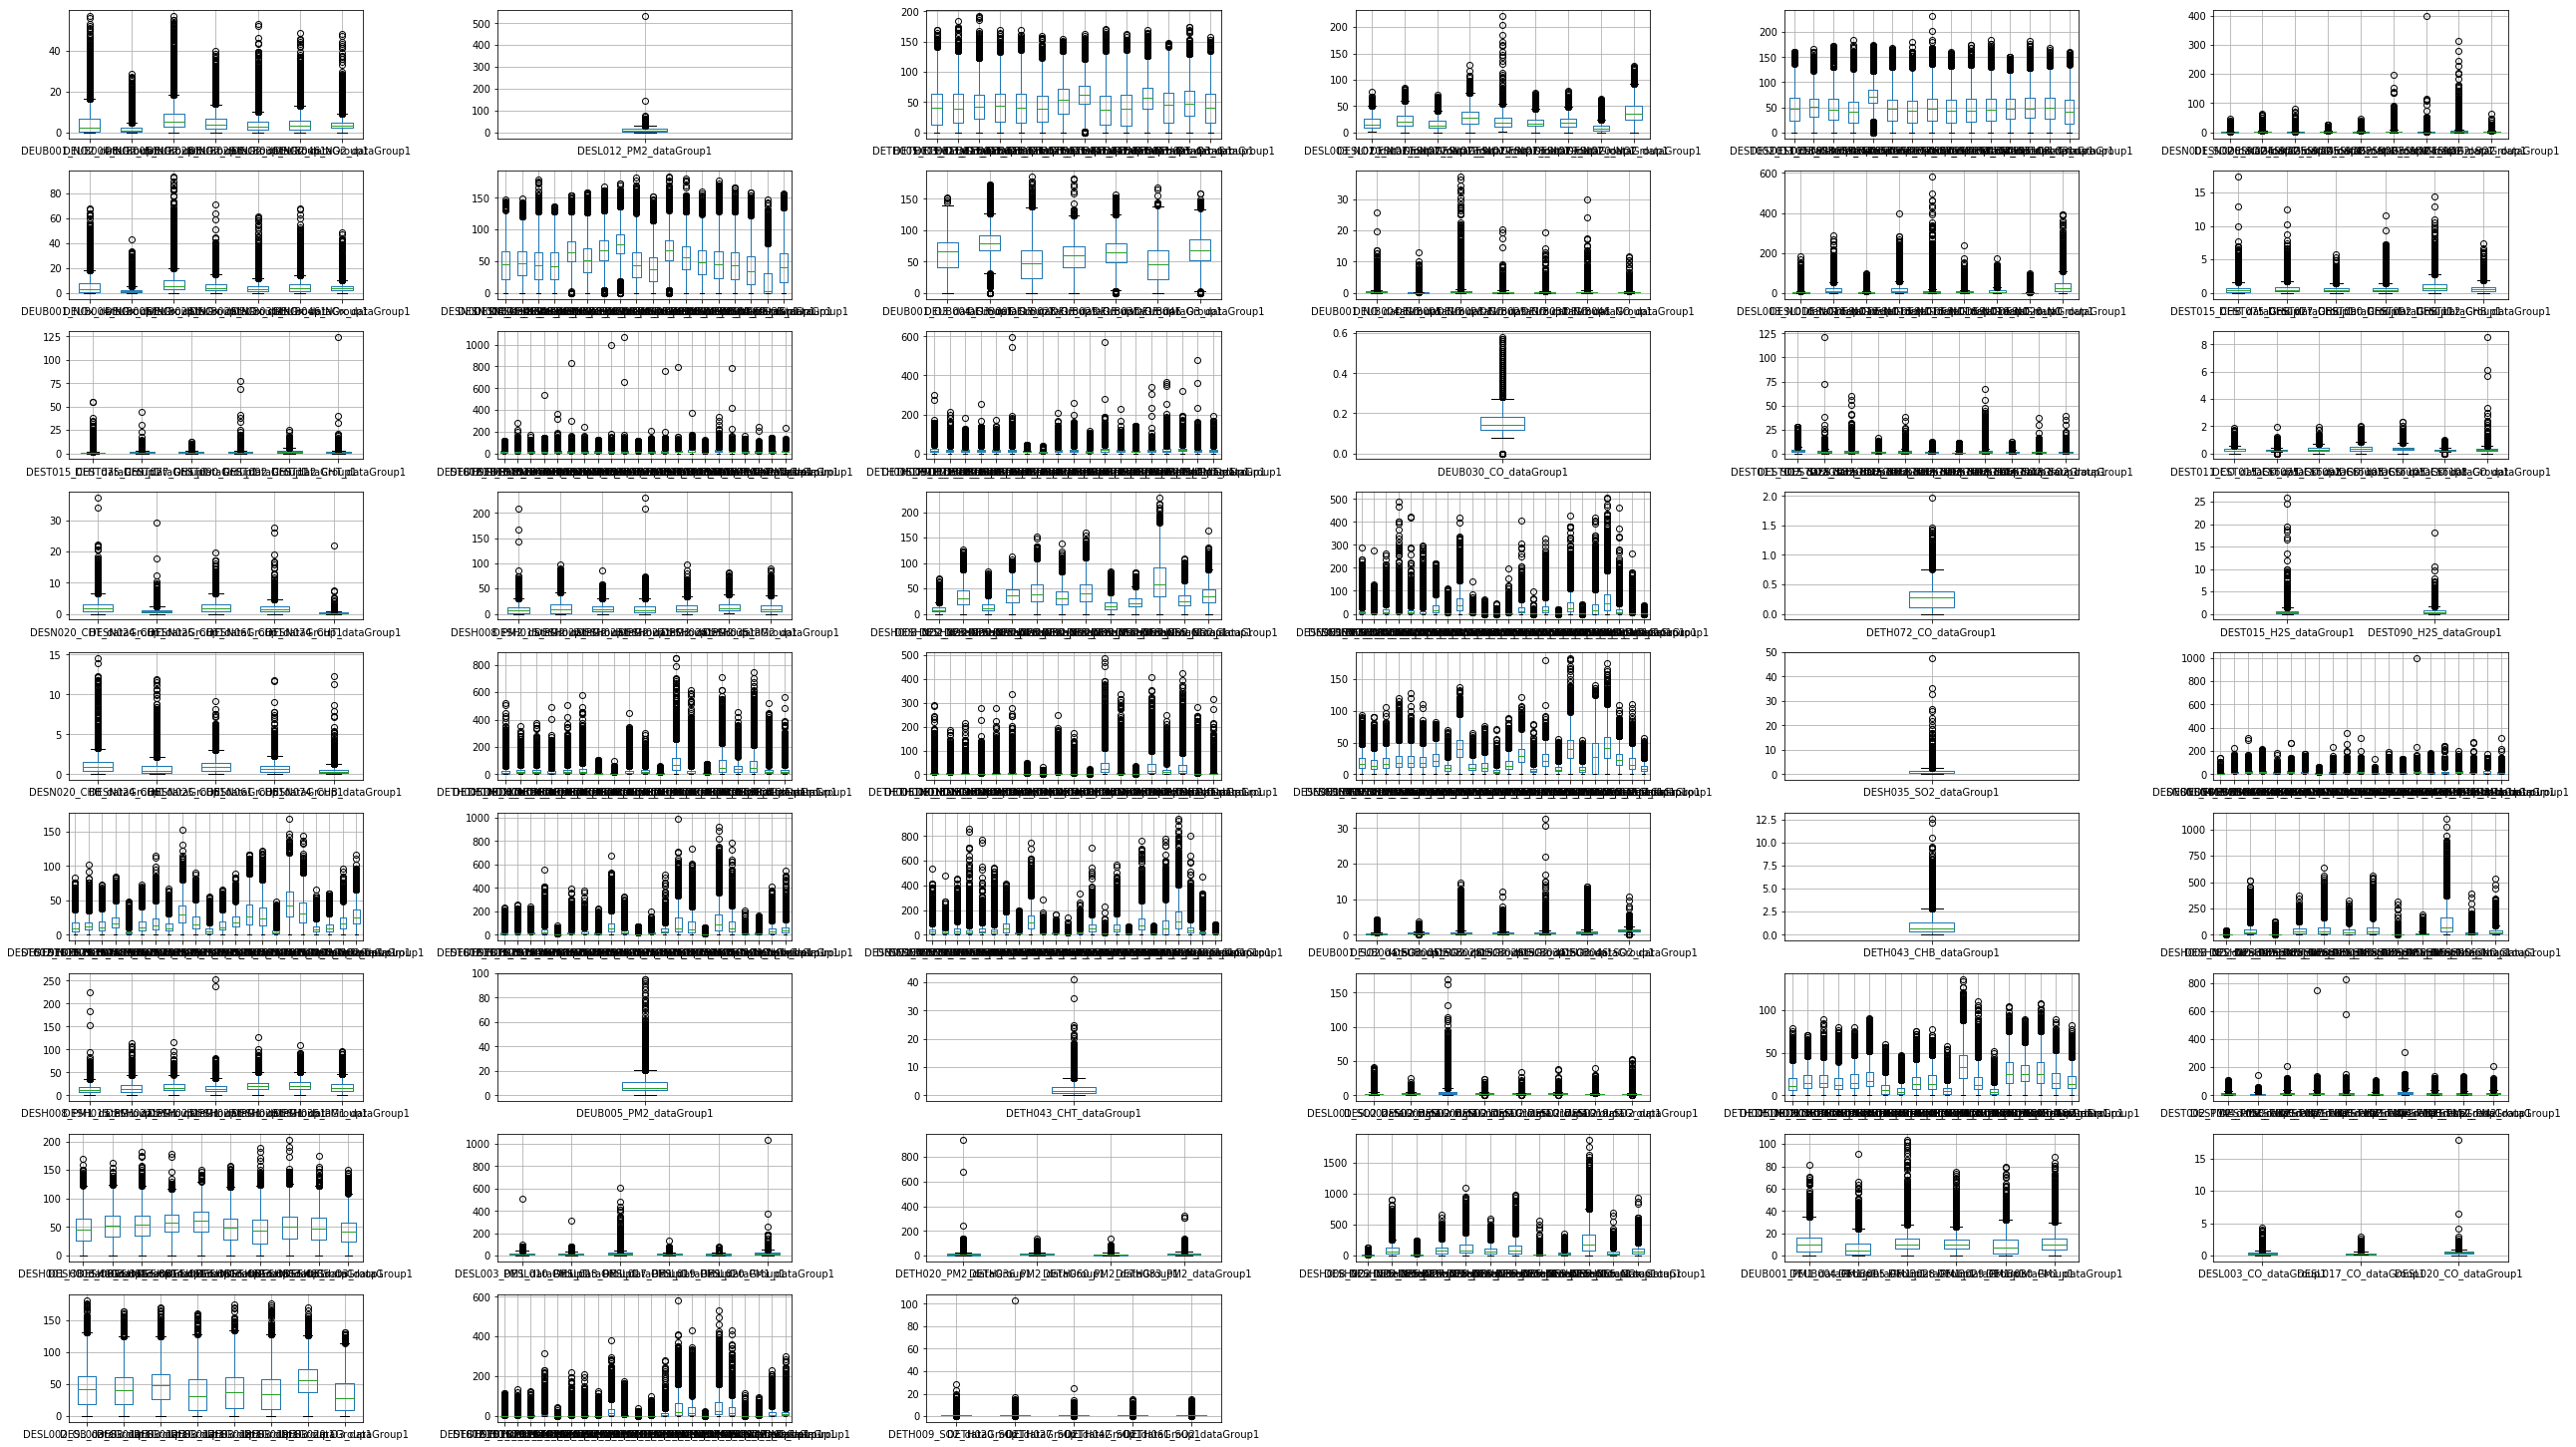

In [20]:
#!ls Capstone.rawData/AQD_DE_E1a_2016/*hour*
FilesHour=[]

for file in os.listdir('Capstone.rawData/AQD_DE_E1a_2016/'):
    if fnmatch.fnmatch(file, '*hour*'):
        FilesHour.append(file)
print(len(FilesHour))

#FilesHour=FilesHour[0:12]        

fig = plt.figure(figsize=(36,58))
NfigRows=26
NfigCols=6


for file in FilesHour:
    Etree = ET.parse('Capstone.rawData/AQD_DE_E1a_2016/'+file)
    Eroot = Etree.getroot()
    Eroot.tag
    Eroot.attrib
    AllTags = [elem.tag for elem in Eroot.iter()]
    
    ColNamesExp=SelectAllXMLsensorID()
    
    varFull = [s for s in AllTags if 'values' in s][0]
    dff=[]
    for varr in Eroot.iter(varFull):
        dff.append(pd.read_csv(StringIO((varr.text).replace("@@","\n")), sep=",", header=None))
    
    dffAll=pd.concat([dff[s][4] for s in range(0,len(dff))], axis=1)
    dffAll.columns=ColNamesExp
    dffAll=dffAll.clip(lower=0)
    
    ax = fig.add_subplot(NfigRows,NfigCols,(FilesHour.index(file)+1))
    ax = (dffAll.boxplot(return_type='both'))
    
plt.tight_layout()
plt.show()

## Sensor position data
Let's examine the xml file with sensor position data. The **sensor IDs** are encoded by *text* of **natlStationCode** and **EUStationCode** tags, and the name of municipality is in *text* of **municipality** tag. More detailed location information, like coordinates (**pos**) and elevation (**altitude**) is available, however it is irrelevant for the present study.

In [21]:
# pick all tags from the XML file
Etree = etree.parse("Capstone.rawData/DE_D_allInOne_metaMeasurements_2016.xml")
Eroot = Etree.getroot()
Eroot.tag
Eroot.attrib
AllTags = [elem.tag for elem in Eroot.iter()]
print(AllTags[23:35])
#varName = 'observedProperty'
#print("\n".join([s for s in AllTags if varName in s])) 

['{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}municipality', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}EUStationCode', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}stationInfo', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}areaClassification', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}altitude', '{http://www.opengis.net/gml/3.2}featureMember', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}AQD_SamplingPoint', '{http://inspire.ec.europa.eu/schemas/ef/3.0}inspireId', '{http://inspire.ec.europa.eu/schemas/base/3.3}Identifier', '{http://inspire.ec.europa.eu/schemas/base/3.3}localId', '{http://inspire.ec.europa.eu/schemas/base/3.3}namespace', '{http://inspire.ec.europa.eu/schemas/base/3.3}versionId']


In [22]:
#len(AllTags)
varMUN = [s for s in AllTags if 'municipality' in s][0]
varID  = [s for s in AllTags if 'EUStationCode' in s][0]
varFeatMem = [s for s in AllTags if 'featureMember' in s][0]


IDs=[]
MUNs=[]

for varr in Eroot.iter(varFeatMem):
    for child in varr.iter(varMUN):
        MUNs.append(child.text)
        for child2 in varr.iter(varID):
            IDs.append(child2.text)
SensorLocation=pd.DataFrame({'SensorID': IDs, 'SensorTown': MUNs})
SensorLocation.tail(5)

,SensorID,SensorTown
762,DEUB005,Lüder
763,DEUB028,Zingst
764,DEUB029,Suhl
765,DEUB030,Stechlin
766,DEUB044,Garmisch-Partenkirchen


### Town-County table
However available **disease statistics** is collected on the **county-averaged base**, not a town-based.
So, the next step will be download of town-county database, and adding a county column(s) to the **SensorLocation** dataset:

In [23]:
columns = [(10, 15), (22, 71), (72, 121)]
dfCT = pd.read_fwf("Capstone.rawData/GV100AD3107/GV100AD_310719.ASC", 
                     colspecs=columns, names=['countyid','town','county'],
                     encoding="iso8859_1")
dfCT=dfCT.fillna(method='ffill')

dfCT['town'] = dfCT['town'].str.split(",").str[0]
dfCT.tail(5)

,countyid,town,county
16116,16077,Starkenberg,Schmölln/Thür.
16117,16077,Thonhausen,Schmölln/Thür.
16118,16077,Treben,Schmölln/Thür.
16119,16077,Vollmershain,Schmölln/Thür.
16120,16077,Windischleuba,Schmölln/Thür.


## Prevalence of Asthma bronchiale
The dataset can be downloaded at https://www.versorgungsatlas.de/fileadmin/excel/data_id_92_kreis11_1_j_1451606400.xlsx in xlsx format:

xls sheet names:  ['Hintergrundinformationen', 'Daten']
      Region  Regions-ID  KV             Kreistyp  Wert  Bundeswert
0   Eisenach       16056  TH    Ländliches Umland   8.9         5.7
1  Sonneberg       16072  TH      Ländlicher Raum   8.7         5.7
2  Ammerland        3451  NI  Verdichtetes Umland   8.5         5.7
Length of the dataset:  402


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f28f7c8b438>]],
      dtype=object)

<Figure size 432x288 with 0 Axes>

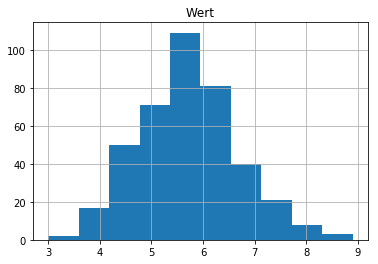

In [24]:
!mkdir Capstone.rawData/Asthma_2016
urllib.request.urlretrieve("https://www.versorgungsatlas.de/fileadmin/excel/data_id_92_kreis11_1_j_1451606400.xlsx", "Capstone.rawData/Asthma_2016/data_id_92_kreis11_1_j_1451606400.xlsx")

xlsx_file = pd.ExcelFile("Capstone.rawData/Asthma_2016/data_id_92_kreis11_1_j_1451606400.xlsx")
print("xls sheet names: ",xlsx_file.sheet_names)
dfAsthma = xlsx_file.parse('Daten', header=3, decimal=",") 
print(dfAsthma.head(3))
print("Length of the dataset: ",len(dfAsthma))
plt.figure()
dfAsthma.hist(column='Wert')

One can see, that the dataset is of length 402, and it contains name and ID of county (**Region**,**Regions-ID**), state ID (**KV**), type of county (**Kreistyp**), normalized value of Asthma bronchiale prevalence (**Wert**), and the prevalence average (**Bundeswert**). The histogram of the normalized value of Asthma bronchiale prevalence is shown above. The data has enough variability to be used in the study.

It also looks like, that the disease prevalence dataset has been averaged w.r.t. short (5-digit) county id, that can be same for different counties. The example is shown below; please note, that all locations are located in South Harz mountains:

In [25]:
dfAsthma.loc[dfAsthma['Regions-ID']==15087]

,Region,Regions-ID,KV,Kreistyp,Wert,Bundeswert
310,Mansfeld-Südharz,15087,ST,Ländlicher Raum,5.0,5.7


In [26]:
dfCT.loc[dfCT['countyid']==15087]

,countyid,town,county
15081,15087,Mansfeld-Südharz,Sangerhausen
15082,15087,Allstedt,Sangerhausen
15083,15087,Arnstein,Sangerhausen
15084,15087,Eisleben,Sangerhausen
15085,15087,Gerbstedt,Sangerhausen
15086,15087,Hettstedt,Sangerhausen
15087,15087,Mansfeld,Sangerhausen
15088,15087,Sangerhausen,Sangerhausen
15089,15087,Seegebiet Mansfelder Land,Sangerhausen
15090,15087,Südharz,Sangerhausen


## Conclusions
The data sets are informative, have sufficient variability, and can be used for the next step (**ETL**)